# Example 1: Function fitting
## SI Section 2.3: One-input two-output functional relationship
### Reference: INN paper https://arxiv.org/abs/2404.10296

In this example, we fit a one-input two-output function described below.

\begin{gathered}
\mathbf{u}(x) = 
\begin{bmatrix}
\sin(2\pi x) \\
\exp(4x^2 - 2x - 1)
\end{bmatrix},
\quad x \in [0,1]
\end{gathered}

From this function, 10,000 randomly sampled data are generated and divided into 70% for training, 15% for validation, and 15% for testing. 

The first step is to import the pyinn package.

In [8]:
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)
import os, sys
import yaml
import importlib

# sys.path.append('../pyinn')  # add parent directory to sys.path
# import dataset_classification, dataset_regression, model, train, plot # for debugging
# importlib.reload(dataset_classification) # To ensure updates to the files are reflected without restarting the kernel,
# importlib.reload(dataset_regression) # use importlib.reload after making changes to the modules:
# importlib.reload(model)
# importlib.reload(train)
# importlib.reload(plot)
from pyinn import dataset_classification, dataset_regression, model, train, plot # with pyinn library


First, set up GPUs

In [9]:
gpu_idx = 2  # set which GPU to run on Athena
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # GPU indexing
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)  # GPU indexing

Next, we create the dataset and store it in /data directory in the current folder. The created datafile will be named as data_name = "1D_2D_sine_exp.csv"

In [10]:
# Define configuration of the dataset & training
data_name = '1D_2D_sine_exp' # data file name in /data directory
config = {}
config["DATA_PARAM"] = {
    "data_name": data_name,  # name of the dataset
    "input_col": [0],
    "output_col": [1,2],

    "bool_data_generation": True,  # data is already stored and splitted
    "data_size": 10_000,
    "split_ratio": [0.7, 0.15, 0.15],  # [0.7,0.15,0.15]

    "bool_normalize": True,  # whether we normalize the input data or not
    "bool_shuffle": True  # whether we shuffle the data
}
config["TRAIN_PARAM"] = {
    "num_epochs_INN": 100,
    "num_epochs_MLP": 100,
    "batch_size": 128,
    "learning_rate": 1e-3,
    "bool_train_acc": True,

    "validation_period": 1,
    "bool_denormalize": False,  # or True, whether we denormalize when measuring errors
    "error_type": "rmse",  # rmse or mse
    "patience": 5
}

# Create dataset and save it in /data directory
data = dataset_regression.Data_regression(data_name, config)
  

loaded 10000 datapoints from 1D_2D_sine_exp dataset


Now the datafile was created at /data/1D_1D_sine_10000.csv. The file name ending with "_10000" denotes the data_size in the config variable. Let us visualize the data using pandas.

In [4]:
import pandas as pd

# Load the CSV file
data_size = int(config["DATA_PARAM"]["data_size"])
df = pd.read_csv(f'./data/{data_name}_{data_size}.csv')

# Display the first few rows
df.head()

,x1,u1,u2
0,0.674595,-0.889850,0.589268
1,0.552262,-0.322503,0.412900
2,0.173402,0.886404,0.293308
3,0.078962,0.476026,0.322071
4,0.130515,0.731181,0.303342


The datafile contains three columns: x1, u1, u2. This is the reason why we set the input_col = [0] and the output_col = [1,2].
Next, we define INN hyperparameters. A user need to define the following hyperparameters:

* nmode: number of modes; integer

The nubmer of tesnor decomposition (TD) modes. Since the current problem's input domain is 1D, we only need nmode = 1. For high dimensional problems (i.e., number of inputs greater than 1), higher number of modes are required.

* nseg: number of segments for each dimension; integer or a list of integers

This hyperparameter determines the grid resolution of an INN model. Notice that TD defines the input space as a regular grid. For instance, when a 3D problem (i.e., number of inputs is 3) is discretized with nseg = 100, the grid becomes a 101 X 101 X 101 uniform grid in 3D domain. The number of grid points in each direction is nseg + 1.

One can also differentiate the discretization of each input dimension. For example, we can discretize a 3D space with a 11 X 51 X 101 uniform grid. In this case, nseg = [10, 50, 100]. 

In the current problem, we set nseg = 5 (i.e., 6 grid points) to match with the benchmarks discussed in Table S4.

* s_patch; integer, 0 <= s_patch < nseg/2

The s_patch determines the number of neighboring segments to be employed for constructing INN interpolation functions. This integer variable should be less than half of the number of segments. Since this hyperparameter controls the support size of INN interpolation functions, a user can draw an educated decision depending on the nature of the problem. For instance, if a solution is expected to fluctuate locally, a small s_patch might be the right choice. 

It is important to note that when s_ptach == 0, the INN message passing Q is set as 1. That is, the linear interpolation functions will be constructed. If s_patch > 0, the INN message passing Q will become 2 and nonlinear interpolation functions will be constructed.

In the current problem, we set s_patch = 2 to match with the benchmarks discussed in Table S4.

* INN activation; string

This hyperparameter is activated when the INN interpolation functions are nonlinear (Q=2). The choices of the INN activation function can be found in Table S3: polynomial, sinusoidal, exponential, sigmoid, tanh, and GELU.

In the current problem, we set "polynomial" to match with the benchamrks discussed in Table S4.

* p_order; integer, p_order <= s_patch

This hyperparameter determines the number of INN activation functions to be incorporated. This corresponds to the variable "P" in Table S3. For instance, when the INN activation is "polynomial" and p_order = 2, the following activation functions will be included during the construction of the INN interpolation functions and the resulting INN interpolation functions will be able to exactly reproduce those INN activation functions:

\begin{gathered}
\begin{bmatrix}
\mathcal{A}_0(x) = 1 \\
\mathcal{A}_1(x) = x \\
\mathcal{A}_2(x) = x^2
\end{bmatrix}.
\end{gathered}

In the current problem, we set p_order = 2 to match with the benchmarks discussed in Table S4.

In [5]:
config["MODEL_PARAM"] = {
    "nmode": 1,
    "nseg": 5,
    "s_patch": 2,
    "INNactivation": "polynomial", # INN activation function, can be 'polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu'
    "p_order": 2,
    ### non-adjustable parameters
    "radial_basis": "cubicSpline",
    "alpha_dil": 20 # this is a dilation parameter and will be set as 20 for default.
}

Let's finalize the configuration file.

In [6]:
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear" # nonlinear (Q=2 INN message passing) interpolation
elif config["MODEL_PARAM"]["s_patch"] == 0:
    config['interp_method'] = "linear" # linear (Q=1 INN message passing) interpolation
config['TD_type'] = "CP"

Train INN (Q=2 nonlinear interpolation)

In [7]:
regressor = train.Regression_INN(data, config)  
regressor.train()  # Train module
params = regressor.params
errors_train, errors_val, errors_epoch = regressor.errors_train, regressor.errors_val, regressor.errors_epoch, 


edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 1, nseg: 5, s=2, P=2 -------------
# of training parameters: 12
Epoch 1
	Train rmse: 4.1248e-01
	Val RMSE: 3.8756e-01
	3.81 seconds per epoch
Epoch 2
	Train rmse: 3.7334e-01
	Val RMSE: 3.5128e-01
	2.01 seconds per epoch
Epoch 3
	Train rmse: 3.3914e-01
	Val RMSE: 3.1952e-01
	1.41 seconds per epoch
Epoch 4
	Train rmse: 3.0902e-01
	Val RMSE: 2.9208e-01
	1.11 seconds per epoch
Epoch 5
	Train rmse: 2.8260e-01
	Val RMSE: 2.6730e-01
	0.93 seconds per epoch
Epoch 6
	Train rmse: 2.5893e-01
	Val RMSE: 2.4547e-01
	0.81 seconds per epoch
Epoch 7
	Train rmse: 2.3781e-01
	Val RMSE: 2.2581e-01
	0.72 seconds per epoch
Epoch 8
	Train rmse: 2.1882e-01
	Val RMSE: 2.0779e-01
	0.66 seconds per epoch
Epoch 9
	Train rmse: 2.0155e-01
	Val RMSE: 1.9175e-01
	0.61 seconds per epoch
Epoch 10
	Train rmse: 1.8592e-01
	Val RMSE: 1.7696e-01
	0.57 seconds per epoch
Epoch 11
	Train rmse: 1.7161e-01
	Val RMSE: 1.6336e-01
	0.54 seconds per epoch
Epoch 12
	T

Plot loss landscape

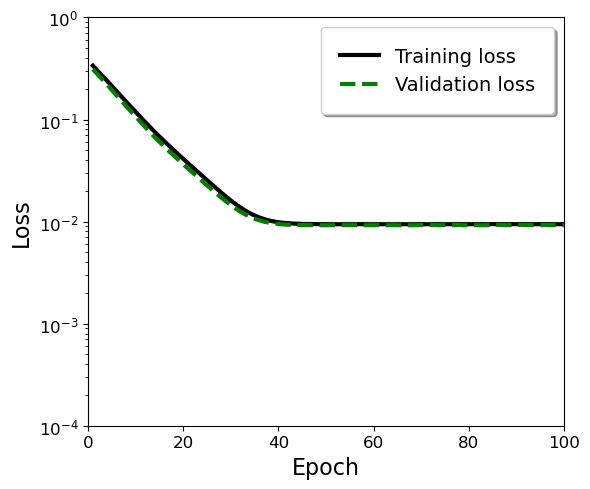

: 

In [ ]:
config["PLOT"] = {"bool_plot": True,
                  "plot_in_axis": [0],  # plot input axis
                  "plot_out_axis": [0, 1]}  # plot output axis
plot.plot_regression(regressor, data, config)